Recurrent Neural Network

데이터가 과거에 입력된 것과 그 후에 입력된 것의 관계를 고려해야할 때 RNN을 사용해서 학습한다.

앞서 입력받은 데이터에 가중치를 둔다. 그 후 다음 데이터를 입력받고 학습한다. 이 과정을 반복한다.

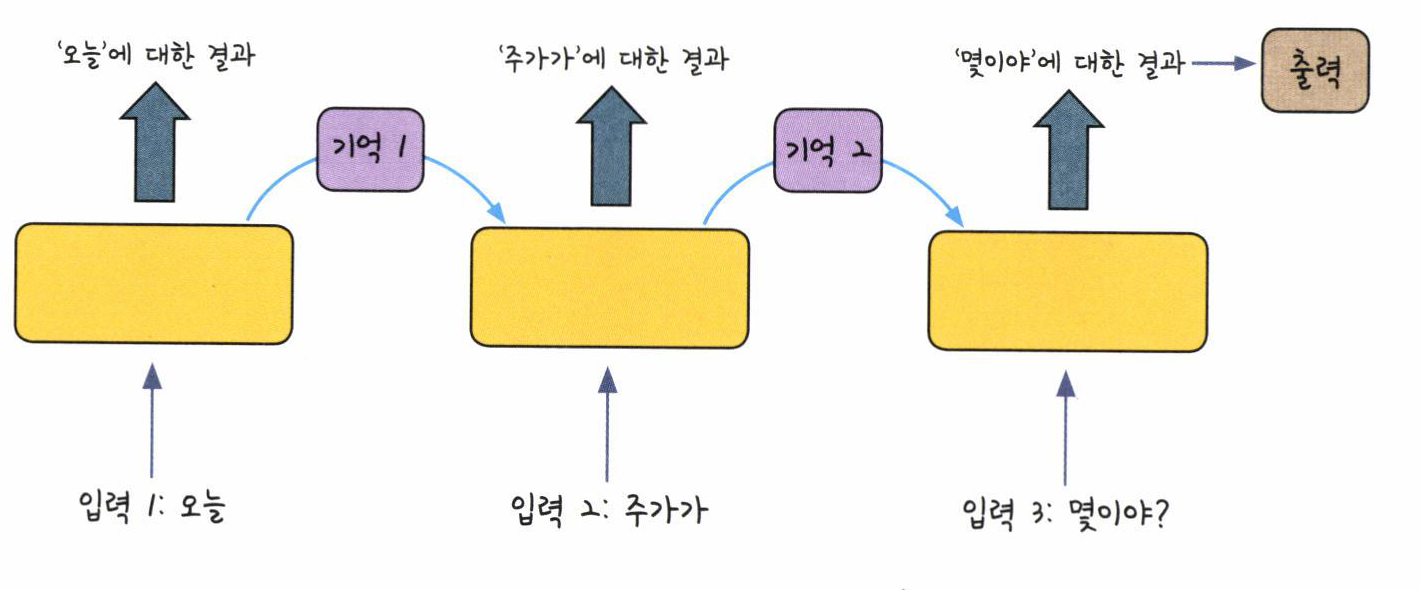

앞서 나온 입력 결과가 후에 받은 입력에 대한 출력 값에 영향을 준다. 이렇게 해야 비슷한 두 문장의 차이를 구별하기 용이하다.

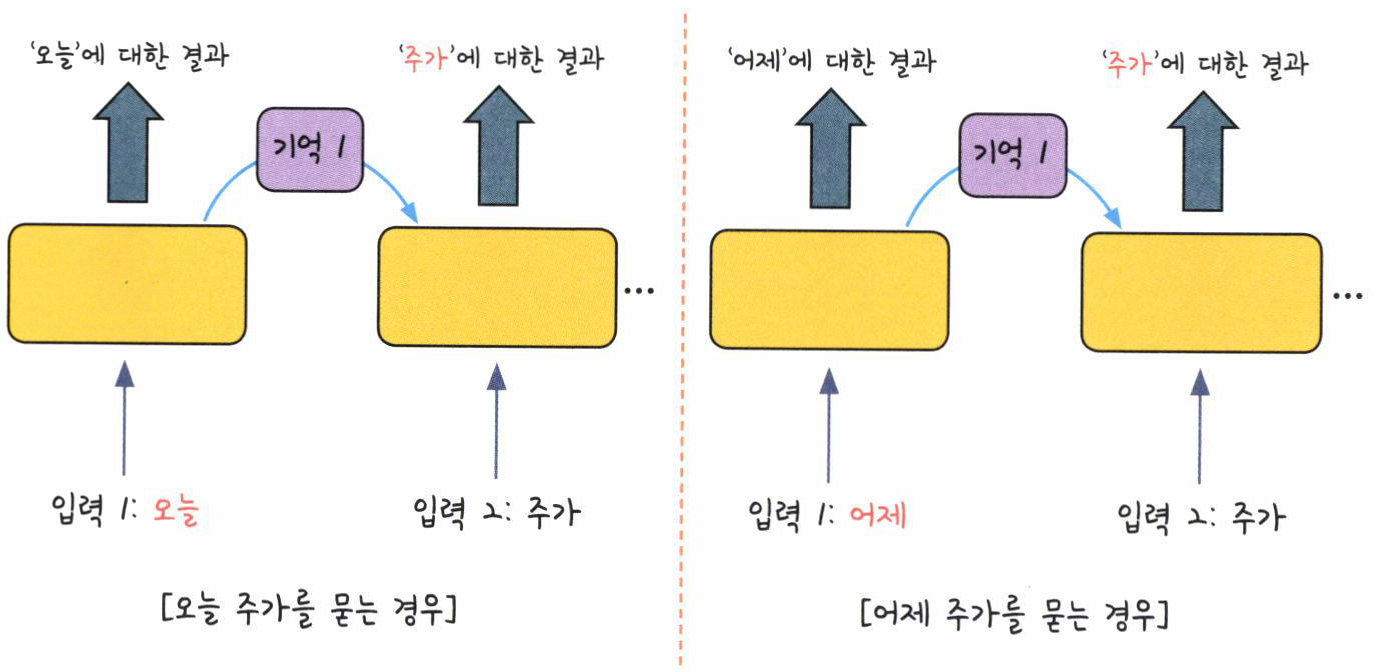

LSTM : Long Short Term Memory

layer 반복이 많으면 gradient 소실 문제가 더 많이 발생한다. LSTM은 이를 보완한 방법이다.

LSTM은 반복되기 직전, 기억한 값을 다음 층으로 넘길 지 안넘길지 결정하는 단계를 둔다.



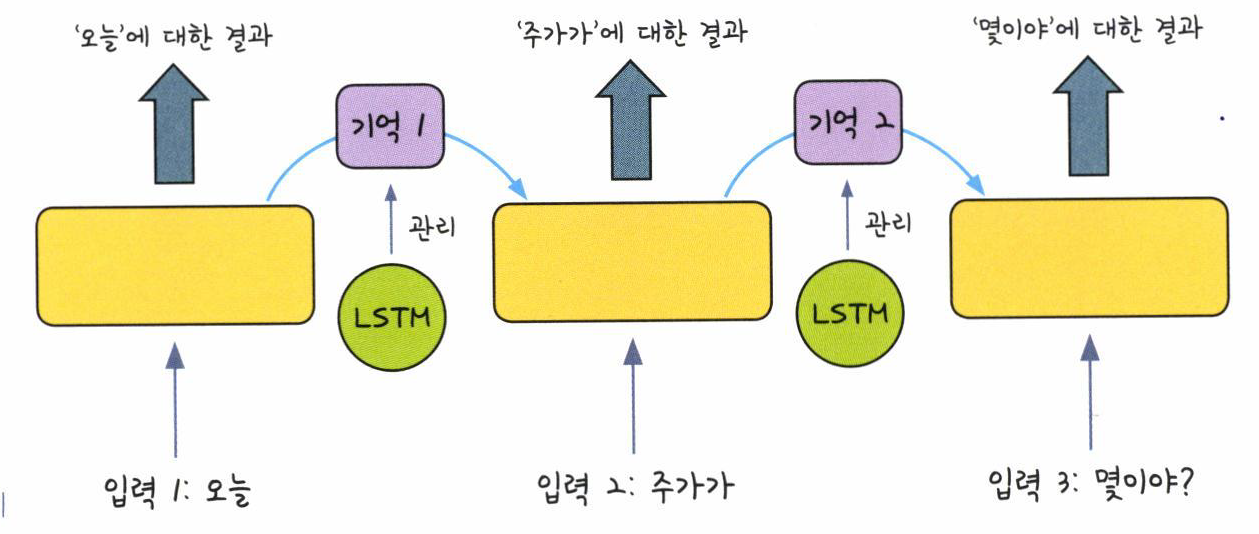

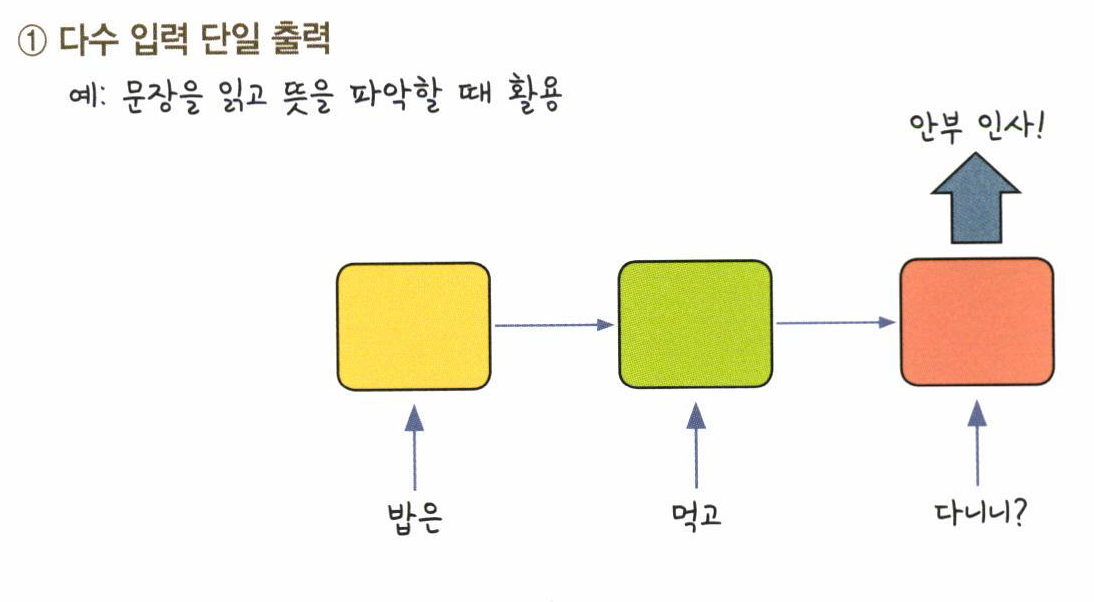

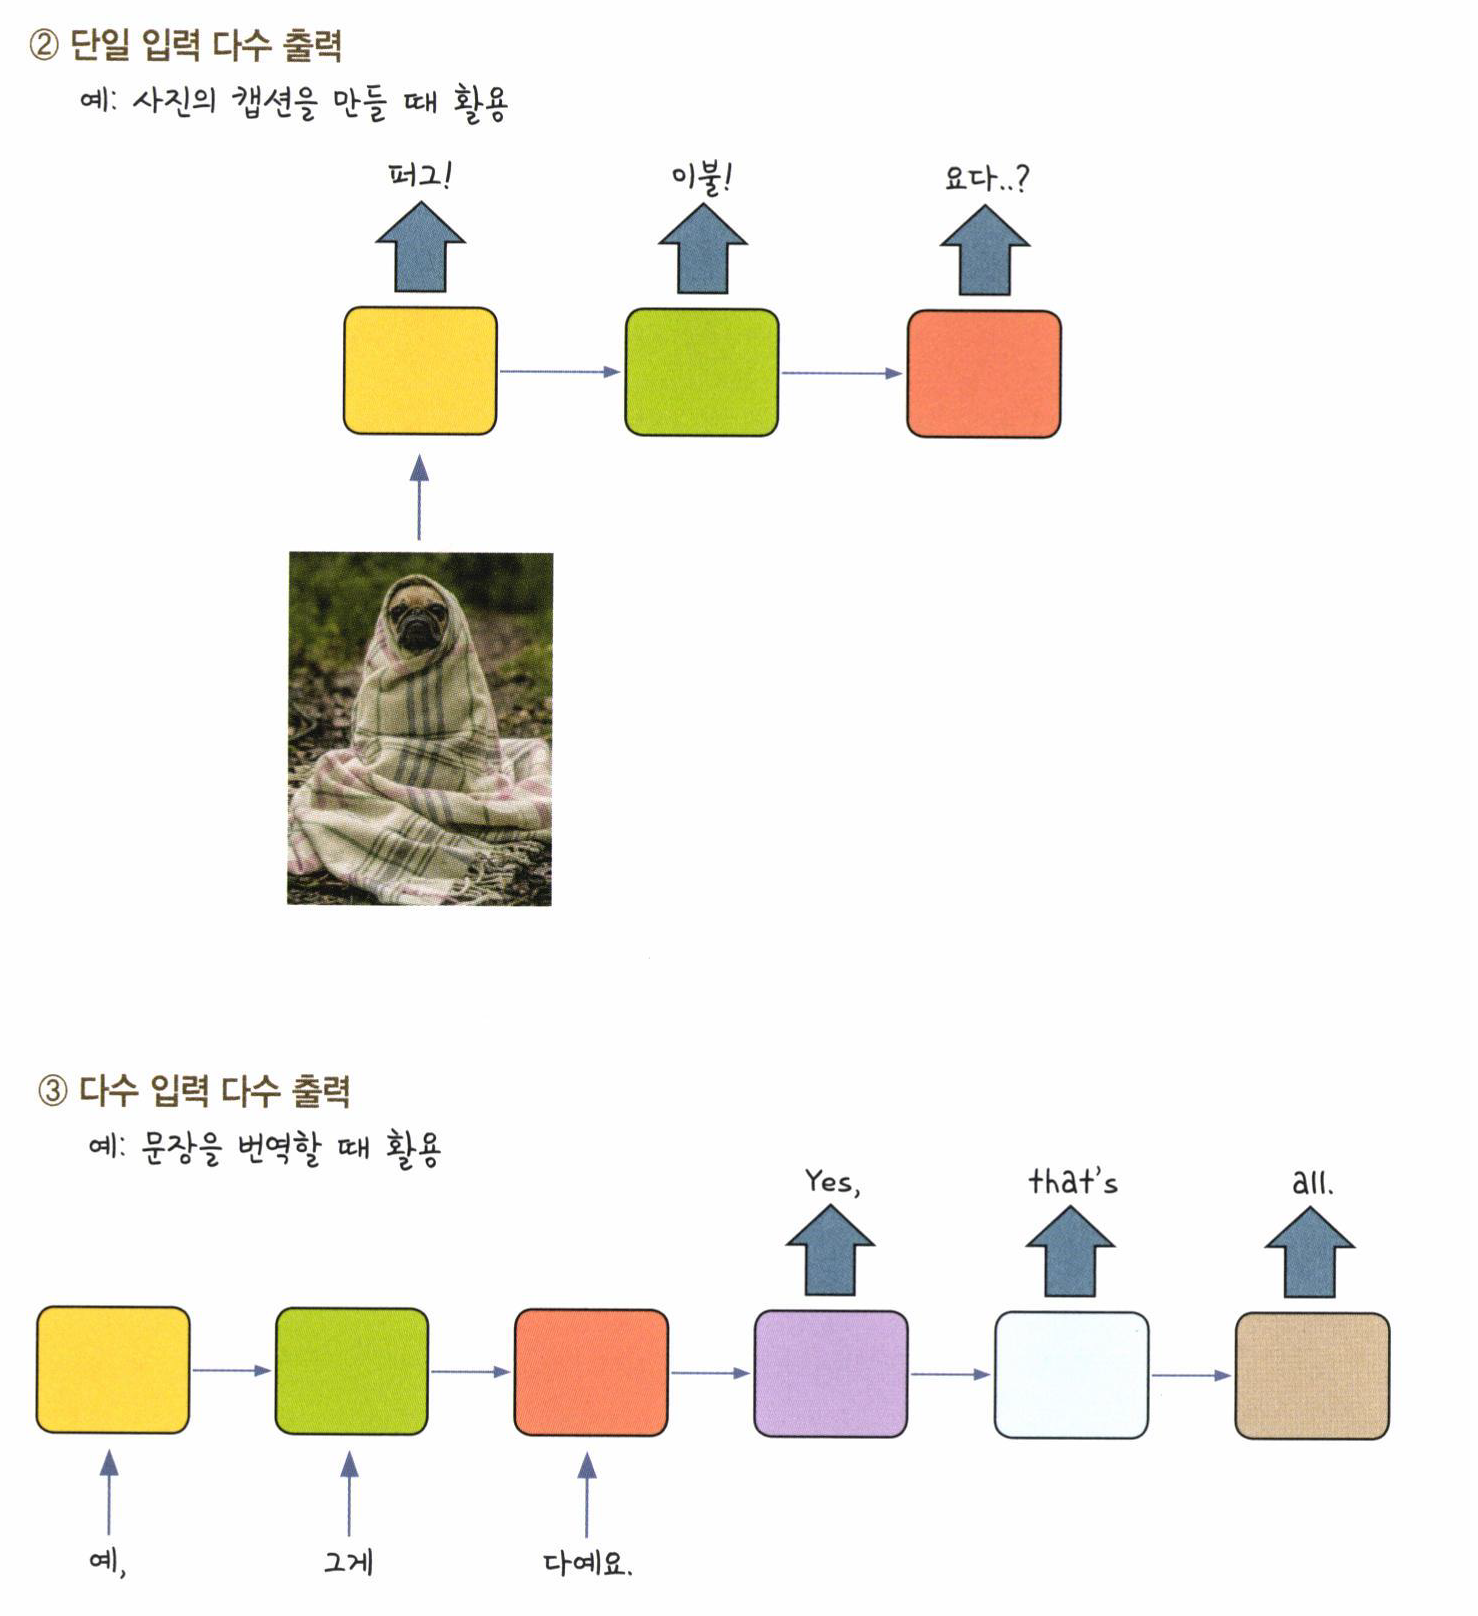

In [4]:
# LSTM으로 긴 텍스트를 읽고 데이터의 카테고리를 분류하자.

# !pip install -q tensorflow-gpu==1.15.0
%tensorflow_version 1.x
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy
import os

# 로이터 뉴스 데이터셋 불러오기
from keras.datasets import reuters   # dataset

# 불러온 데이터를 학습셋, 테스트셋으로 나누기
# load_data()를 이용해 RNN dataset을 다운받는다.
# test-set 20%, 빈도 1 ~ 1000 인 단어 load
(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words=1000, test_split=0.2)

# 데이터 확인하기
category = numpy.max(Y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])
print(len(X_train[0]))

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


/tensorflow-1.15.2/python3.7/keras/datasets/reuters.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/tensorflow-1.15.2/python3.7/keras/datasets/reuters.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


x_train은 문장에서 나타난 단어들을, 빈도 순으로 index를 붙인 것이다. 즉, 이미 tokenizer() 작업을 마친 상태로 온 것이다.



Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 8982 samples, validate on 2246 samples
Epoch 1/20
8982/8982 [==============================] - 27s 3ms/step - loss: 2.5409 - accuracy: 0.3743 - val_loss: 2.0280 - val_accuracy: 0.4987
Epoch 2/20
8982/8982 [==============================] - 26s 3ms/step - loss: 2.0362 - accuracy: 0.4814 - val_loss: 2.4082 - val_accuracy: 0.3646
Epoch 3/20
8982/8982 [==============================] - 26s 3ms/step - loss: 2.0662 - accuracy: 0.4638 - val_loss: 1.9158 - val_accuracy: 0.5138
Epoch 4/20
8982/8982 [==============================] - 26s 3ms/step - loss: 1.8065 - accuracy: 0.5325 - val_loss: 1.7608 - val_accuracy: 0.5516
Epoch 5/20
8982/8982 [==============================] - 26s 3ms/step - loss: 1.7152 - accuracy: 0.5559 - val_loss: 1.7659 - val_accuracy: 0.5574
Epoch 6/20
8982/8982 [==============================] - 27s 3ms/step - loss: 1.6542 - accuracy: 0.5777 - val_loss: 1.7164 - val_accuracy: 0.5632


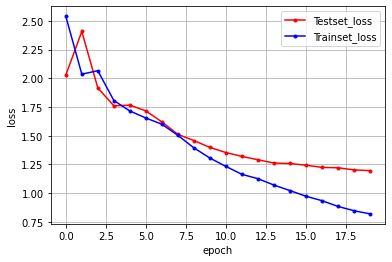

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils

# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.compat.v1.set_random_seed(3)

# 데이터 전처리
# 기사의 단어 수를 동일하게 맞춰준다.
# 단어 수를 100으로 맞춘다는 뜻. 모자란 부분은 0으로 채운다.
x_train = sequence.pad_sequences(X_train, maxlen=100)
x_test = sequence.pad_sequences(X_test, maxlen=100)
y_train = np_utils.to_categorical(Y_train)
y_test = np_utils.to_categorical(Y_test)


# 모델의 설정
# Embedding, LSTM layer를 추가한다.
model = Sequential()
model.add(Embedding(1000, 100))    # 불러온 단어의 총 개수(빈도 1000까지의 단어를가져왔다.), 기사당 단어 수(100개로 sequence를 통해 맞췄다.)
model.add(LSTM(100, activation='tanh'))    # 기사 당 단어 수, 활성화함수
model.add(Dense(46, activation='softmax'))

# 모델의 컴파일
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# 모델의 실행
history = model.fit(x_train, y_train, batch_size=100, epochs=20, validation_data=(x_test, y_test))

# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(x_test, y_test)[1]))

# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
